## Семинар 10: "Генерация текстов"

ФИО: Салихова Кария Илшатовна

In [0]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

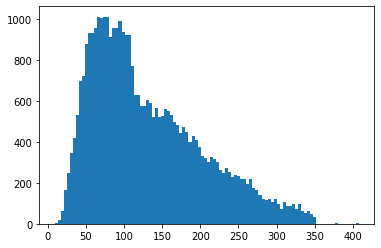

In [3]:
plt.hist(list(map(len, lines)), bins=100);

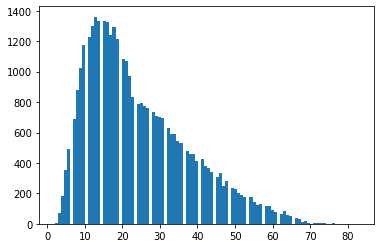

In [4]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [0]:
line = lines[0]

In [6]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [0]:
lines = list(filter(lambda x: len(x.split()) <= 50, lines))

In [8]:
np.random.seed(777)
torch.random.manual_seed(777)

In [0]:
class Vocabulary:
    def __init__(self, sentences):
        self.all_characters = set()
        for line in sentences:
            self.all_characters |= set(line)
        self.all_characters = list(sorted(self.all_characters))+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(self.all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(self.all_characters)}
        self.size = len(self.all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [0]:
vocab = Vocabulary(lines)

In [0]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [0]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [0]:
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [0]:
dataset = Quotes(lines, vocab)

In [0]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

### Часть 2: определение модели

In [0]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [0]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [0]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [0]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [0]:
losses = []

In [0]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

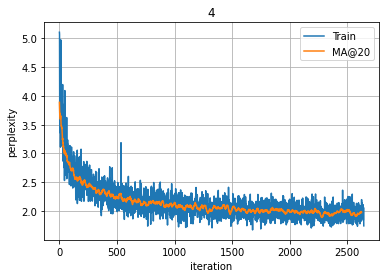

100%|██████████| 536/536 [14:19<00:00,  1.60s/it]


In [0]:
for epoch in range(5):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.title(epoch)
            plt.legend()
            plt.grid()
            plt.show()

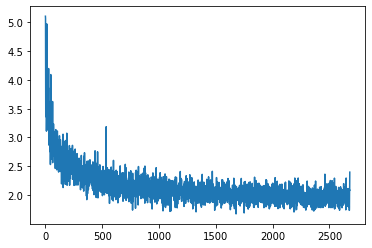

In [0]:
plt.plot(losses)

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [0]:
for i in range(10):
  print(oracle.generate(vocab))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The provide panised obstrations when the mids, and my world that him is practing a jsomism. There's 
WY hasful treedom idistrably, but a stroz. Jut he tanketent bremer gots more so me what it to gived 
I got do that 'neights being 100 what show to motten.<eos>
The cirllives.<eos>
As the need.<eos>
We are always filtters than can say.<eos>
Alited your screolod to cau unless rainst peopleh's enjoposited to learn strack how that the heards 
It want all writp heals limicians can destine to get artist being sense to ou one are happ atortance
I have some to Ameritice.<eos>
You suntrie I use any vesting to untatted it mas, it's motist you.<eos>


## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [0]:
class lstm_Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(lstm_Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = (Variable(torch.zeros(self.layers, 1, self.hidden_size)),
             Variable(torch.zeros(self.layers, 1, self.hidden_size)))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [0]:
lstm_oracle = lstm_Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

In [0]:
optimizer = torch.optim.RMSprop(lstm_oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [0]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [0]:
#разобьем на train/test множества в той же пропорции, как на прошлом семинаре про LSTM
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

In [0]:
train_dataset = Quotes(lines[:train_size], vocab)
test_dataset = Quotes(lines[train_size:], vocab)

In [0]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

In [0]:
import tqdm

100%|██████████| 177/177 [00:27<00:00,  6.51it/s]


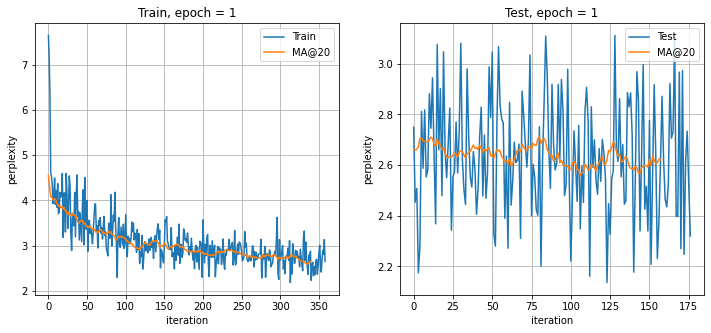

100%|██████████| 177/177 [00:26<00:00,  6.71it/s]


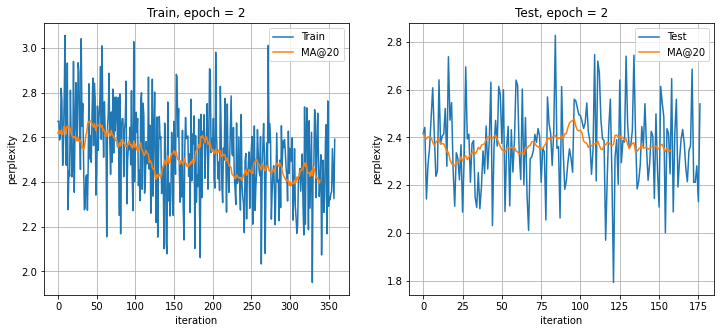

100%|██████████| 177/177 [00:26<00:00,  6.74it/s]


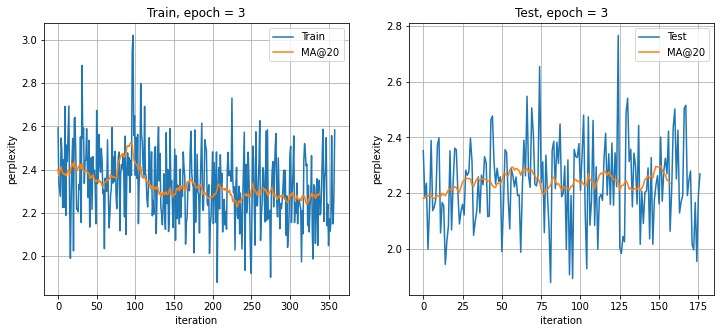

100%|██████████| 177/177 [00:26<00:00,  6.72it/s]


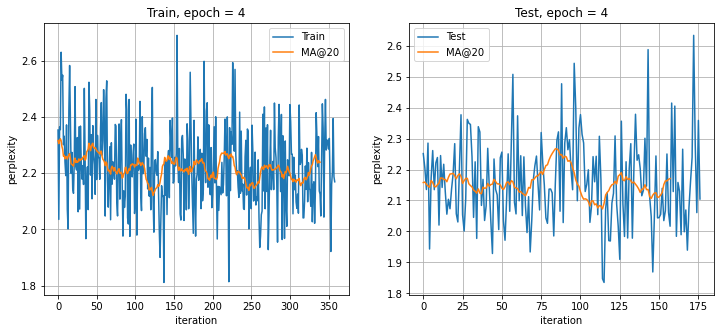

In [0]:
k = 0
all_train_losses = []
all_test_losses = []
mean_train = []
mean_test = []
for epoch in range(4):
    train_losses = []
    test_losses = []
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(train_dataloader,
                                                          total=len(train_dataloader), position=0, leave=True)):
        lstm_oracle.zero_grad()
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        train_loss = (criterion(prediction, eos) * mask.float()).mean()
        train_loss.backward()
        [x.grad.clamp_(-1, 1) for x in lstm_oracle.parameters()]
        optimizer.step()
        all_train_losses.append(np.exp(train_loss.item()))
        train_losses.append(np.exp(train_loss.item()))
    mean_train.append(np.mean(train_losses))
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(test_dataloader, 
                                                          total=len(test_dataloader), position=0, leave=True)):
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        test_loss = (criterion(prediction, eos) * mask.float()).mean()
        all_test_losses.append(np.exp(test_loss.item()))
        test_losses.append(np.exp(test_loss.item()))
    mean_test.append(np.mean(test_losses))
    #clear_output(True)
    plt.figure(figsize=(12, 5))
    k += 1
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(moving_average(train_losses), label='MA@20')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.title("Train, epoch = {}".format(epoch+1))
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(test_losses, label='Test')
    plt.plot(moving_average(test_losses), label='MA@20')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.title("Test, epoch = {}".format(epoch+1))
    plt.legend()
    plt.grid()
    plt.show()

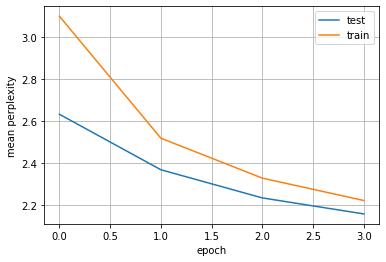

In [0]:
plt.plot(mean_test, label='test')
plt.plot(mean_train, label='train')
plt.xlabel('epoch')
plt.ylabel('mean perplexity')
plt.grid()
plt.legend()
plt.show()

In [0]:
emb_size = [32, 64, 128]
hid_size = [32, 64]
num_layers = [2, 4]

In [23]:
opt_loss = 5000
for embedding_size in emb_size:
  for hidden_size in hid_size:
    for layers in num_layers:
      losses = []
      lstm_oracle = lstm_Oracle(vocab.size, embedding_size=embedding_size,
                                hidden_size=hidden_size, layers=layers)
      optimizer = torch.optim.RMSprop(lstm_oracle.parameters(), lr=0.001, weight_decay=1e-5)
      criterion = nn.CrossEntropyLoss(reduction='none')
      for epoch in range(1):
        bar = progressbar.ProgressBar()
        for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader,
                                                              total=len(dataloader), position=0, leave=True)):
          lstm_oracle.zero_grad()
          prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
          loss = (criterion(prediction, eos)*mask.float()).mean()
          loss.backward()
          [x.grad.clamp_(-1, 1) for x in lstm_oracle.parameters()]
          optimizer.step()
          losses.append(np.exp(loss.item()))
    if loss < opt_loss:
      opt_loss = loss
      opt_model = lstm_oracle
      opt_embedding_size = embedding_size
      opt_hidden_size = hidden_size
      opt_layers = layers
      opt_losses = losses

100%|██████████| 536/536 [46:22<00:00,  5.19s/it]


In [24]:
opt_model

lstm_Oracle(
  (embedding): Embedding(84, 64)
  (generator): LSTM(64, 64, num_layers=4)
  (classifier): Linear(in_features=64, out_features=84, bias=True)
)

In [25]:
opt_loss

tensor(1.0322, grad_fn=<MeanBackward0>)

In [26]:
opt_embedding_size, opt_hidden_size, opt_layers

(64, 64, 4)

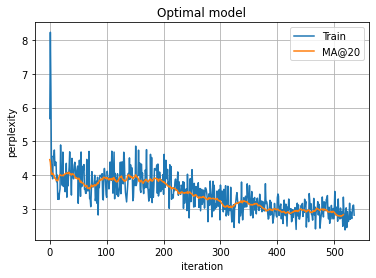

In [27]:
plt.plot(opt_losses, label='Train')
plt.plot(moving_average(opt_losses), label='MA@20')
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.title("Optimal model")
plt.legend()
plt.grid()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: